# Lomb-Scargle periodogram
In this notebook we are going to analyse the time-series in a test-dataset using periodograms. There are meant to capture seasonality in time-series, let's dive into it.

## Load data

In [1]:
import pickle
with open(f"../../data/1188_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
data_obs = data['data']

## Periodograms
Let's look how the frequencies band affect the results that one get. Also, we want to understand which kind of seasonality exists in our data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle, find_peaks

In [3]:
# frequency band: time in days to make it more understandable.
freq = np.linspace(0.2/365, 10/365, 1000) #(cycles per day) 
freq_angular = 2 * np.pi * freq  # angular frequencies that's how the function requires it)
num_peaks = 1  # number of peaks to detect

<Figure size 3000x1000 with 0 Axes>

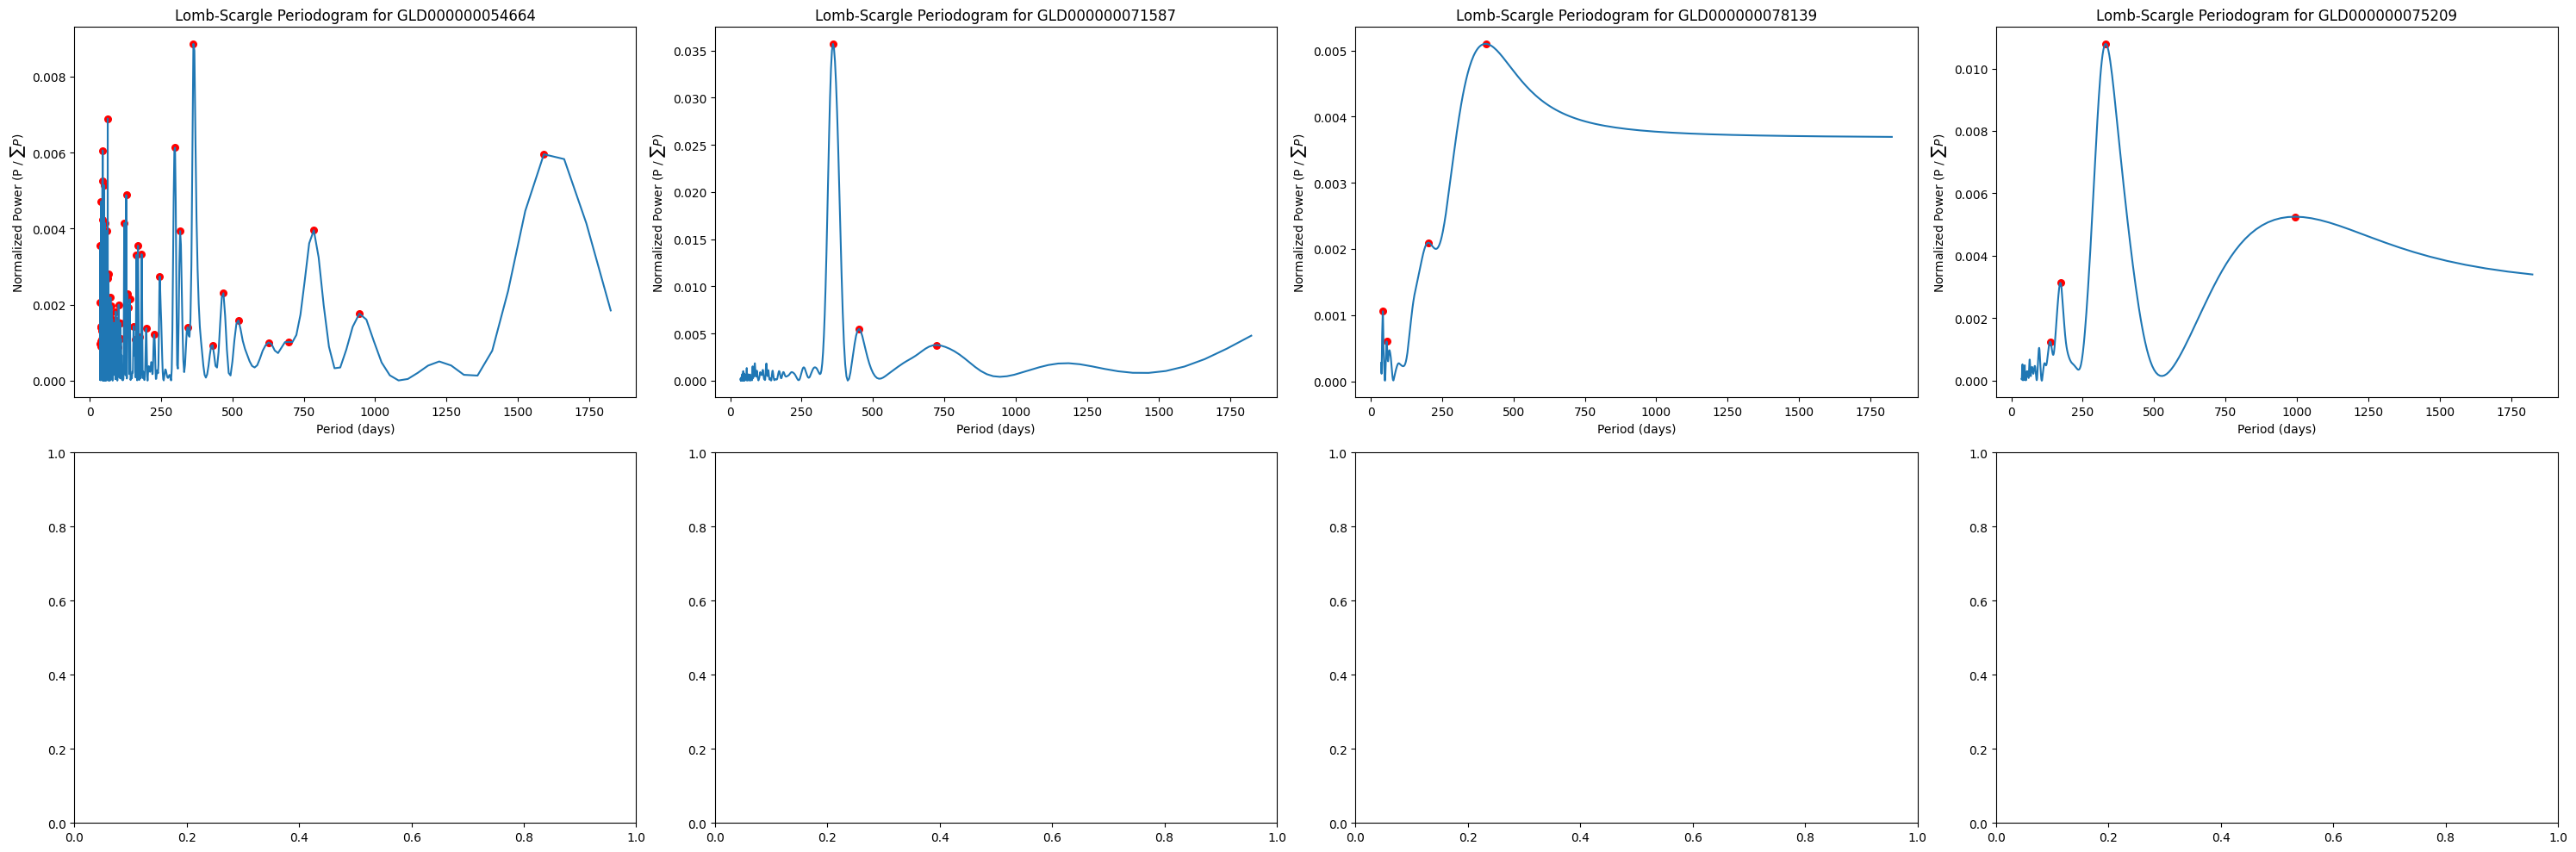

In [15]:
# Loop trough the data
plt.figure(figsize=(30, 10))
num_plots = 4
p, p_no_pgram = 0, 0 
fig, axes = plt.subplots(2, num_plots, figsize=(30, 10))
pgram_data = []
for i, gld in enumerate(data_obs.keys()):
    dino_ts = data_obs[gld]['dino']
    # normalization (is it needed?)
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    times_days = (dino_ts[:, 0] - dino_ts[0, 0]) / 1000 / 86400  # convert from unix ms to days, start at 0
    pgram = lombscargle(times_days, dino_ts[:, 1], freq_angular) # frequencies are angular
    p_max = pgram.max()
    if p_max <= 0: continue # skip periodograms with no power (no seasonality)
    p_norm = pgram / np.sum(pgram)
    p_rel = pgram / p_max
    
    # Peak detection
    peaks, _ = find_peaks(pgram, height=p_max*0.1)  # peaks higher than 10% of max
    peak_periods = 1 / freq[peaks]
    if len(peaks) >= num_peaks: # skip periodograms with no power (no seasonality)
        order = np.argsort(pgram[peaks])[::-1]
        row = {'GLD': gld}
        for k, j in enumerate(order[:num_peaks]):
            #print(f"{gld} Peak: period = {peak_periods[j]:.1f} days, power = {pgram[peaks[j]]:.3f}, normalized power: {p_norm[peaks[j]]:.3f}")
            row[f'period_{k+1}'] = peak_periods[j] # period (days)
            row[f'p_norm_peak_{k+1}'] = p_norm[peaks[j]]
            row[f'p_rel_peak_{k+1}'] = p_rel[peaks[j]]
        pgram_data.append(row)
    
        if p < num_plots:
            ax = axes[0, p]
            p += 1
            ax.scatter(peak_periods, p_norm[peaks], color='r', s=30, label='peaks')
            ax.plot(1/freq, p_norm)
            ax.set_title(f'Lomb-Scargle Periodogram for {gld}')
            ax.set_xlabel('Period (days)')
            ax.set_ylabel('Normalized Power (P / $\\sum{P}$)')
    elif len(peaks) < 2:
        if p_no_pgram < num_plots:
            ax = axes[1, p_no_pgram]
            p_no_pgram += 1
            ax.scatter(peak_periods, p_norm[peaks], color='r', s=30, label='peaks')
            ax.plot(1/freq, p_norm)
            ax.set_title(f'Lomb-Scargle Periodogram for {gld}')
            ax.set_xlabel('Period (days)')
            ax.set_ylabel('Normalized Power (P / $\\sum{P}$)')

plt.tight_layout();

In [5]:
pgram_df = pd.DataFrame(pgram_data).set_index('GLD')
pgram_df.head()

,period_1,p_norm_peak_1,p_rel_peak_1
GLD,,,
GLD000000054664,363.399442,0.008860,1.0
GLD000000071587,359.884524,0.035699,1.0
GLD000000078139,402.733598,0.005101,1.0
GLD000000075209,331.065008,0.010790,1.0
GLD000000059933,59.878317,0.005316,1.0


In [6]:
# Statistics
print(f"Number of series with seasonality in the defined band: {len(pgram_data)} ({len(pgram_data) / len(data_obs) * 100:.1f}%)")
print(f"Number of NaNs (less that {num_peaks=} found): {pgram_df.isna().sum().sum()}")
print(f"Average of the strongest period: {pgram_df['period_1'].mean(skipna=True):.2f} days ± {pgram_df['period_1'].std(skipna=True):.2f}")


Number of series with seasonality in the defined band: 1188 (100.0%)
Number of NaNs (less that num_peaks=1 found): 0
Average of the strongest period: 479.21 days ± 366.11


## Interactive plot

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle, find_peaks
from ipywidgets import interact, FloatSlider, IntSlider, FloatLogSlider
import ipywidgets as widgets

In [8]:
def compute_ls(t, y, freq_min, freq_max, n_freqs):
    """Compute Lomb–Scargle periodogram and detect peaks."""
    t = (np.asarray(t) - np.nanmin(t)) / 1000 / 86400 # Shift time so it starts at 0, convert to days.
    y = np.asarray(y) - np.nanmean(y)
    if len(t) < 5: return np.array([]), np.array([])
    freqs = np.linspace(freq_min, freq_max, n_freqs)
    p = lombscargle(t, y, 2 * np.pi * freqs)
    return freqs, p

In [13]:
def ls_viewer(data_obs):
    glds = list(data_obs.keys())

    dropdown = widgets.Dropdown(options=glds, description='BRO_ID:')

    @interact(
        gld=dropdown,
        freq_min=FloatLogSlider(value=1e-4, base=10, min=-5, max=-2, step=0.1, description='f_min'),
        freq_max=FloatLogSlider(value=0.02, base=10, min=-3, max=0, step=0.1, description='f_max'),
        n_freqs=IntSlider(value=1500, min=50, max=10_000, step=50, description='n_freqs'),
        height_ratio=FloatSlider(value=0.1, min=0.0, max=1.0, step=0.05, description='height'),
    )
    def _plot(gld, freq_min, freq_max, n_freqs, height_ratio):
        dino_ts = data_obs[gld]['dino']
        freqs, p, = compute_ls(
            dino_ts[:, 0], dino_ts[:, 1],
            freq_min=freq_min,
            freq_max=freq_max,
            n_freqs=n_freqs,
        )

        # Peak detection
        peak_kw = {}
        if height_ratio > 0:
            thr = p.max() * height_ratio
            peak_kw['height'] = thr
        peaks, _ = find_peaks(p, **peak_kw)

        periods = 1 / freqs
        dominance = 0
        if len(peaks) > 1:
            powers = np.sort(p[peaks])[::-1]
            dominance = powers[0] / (powers[:min(5, len(powers))].sum() + 1e-12)

        _, ax = plt.subplots(1, 2, figsize=(12, 4))
        # time series
        ax[0].plot(dino_ts[:, 0], dino_ts[:, 1], lw=1)
        ax[0].set_title(f"Time Series {gld}")
        ax[0].set_xlabel("Time [ms]")
        ax[0].set_ylabel("Groundwater Level (normalized)")

        # periodogram
        ax[1].plot(periods, p, color="k", lw=1)
        if len(peaks):
            ax[1].scatter(periods[peaks], p[peaks], color='red', s=30)
        ax[1].set_xlabel("Period [days]")
        ax[1].set_ylabel("Normalized Power")
        ax[1].set_title(f"Peaks={len(peaks)} | Dominance={dominance:.3f}")

        plt.tight_layout()
        plt.show()

In [14]:
ls_viewer(data_obs)

interactive(children=(Dropdown(description='BRO_ID:', options=('GLD000000054664', 'GLD000000071587', 'GLD00000…